<a href="https://colab.research.google.com/github/sravanisasu/BERT_Regression/blob/main/RNN_10K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**git clone dataset**

In [1]:
!git clone https://github.com/sravanisasu/10k-sample

Cloning into '10k-sample'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9557 (delta 1), reused 1 (delta 0), pack-reused 9548
Receiving objects: 100% (9557/9557), 158.15 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Checking out files: 100% (10020/10020), done.


**required imports**

In [5]:
# Importing the required packages

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
from numpy import random
from pickle import load
from numpy import array
import os
import re
import pandas as pd
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras import optimizers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.recurrent import LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**building embedding for the words**

In [6]:
#Define file paths required for the model

# embedding bin file
embed_file = "/content/sim.expand.200d.vec"

#Define Hyper parameters
max_inp_len = 20000
# the dimension of vectors to be used
embed_dim = 200
rounding = 6
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 1
pool_size = 199
# dropout probability
drop = 0.5
batch_size = 50
learning_rate = 0.001
epochs = 30

In [7]:
#define embedding dictionary and embed matrix for the vocabulary
embeddings_dic = dict()
f = open(embed_file,encoding='utf8')
with open(embed_file, 'r', encoding='utf-8') as e_file:
  for line in e_file:
    splitlines = line.split()
    word = splitlines[0].strip()
    coefs = np.asarray(splitlines[1:], dtype='float32')
    embeddings_dic[word] = coefs

print("length of embedding dictionary",len(embeddings_dic))

length of embedding dictionary 70429


In [8]:
vocabulary_size = len(embeddings_dic.keys())
embed_token = Tokenizer()
embed_token.fit_on_texts(embeddings_dic.keys())
embedding_matrix = np.zeros((vocabulary_size, embed_dim))
for word, index in embed_token.word_index.items():
  embedding_matrix[index] = embeddings_dic.get(word)
print("embedding_matrix dimension",len(embedding_matrix),len(embedding_matrix[0]))
print("no of token in the tokenizer",len(embed_token.word_index) + 1)

embedding_matrix dimension 70429 200
no of token in the tokenizer 70429


**Pre processing input and output**

In [9]:
#function to pre process the document
def process_doc(path_file,embed_token) :

  #tokenizing the words 
  with open(path_file,'r', encoding='utf-8') as tok_file :
    file_words = list(tok_file)[0].split()
    
  #removing the stop words
  stop_words = set(stopwords.words('english'))
  filtered_words = []  
  for word in file_words: 
      if word not in stop_words and word.isalpha(): 
          filtered_words.append(word)

  # applying stemming using PorterStemmer

  p_stemmer = PorterStemmer()
  stem_words=[]
  for word in filtered_words:
    stem_words.append(p_stemmer.stem(word))
    
  #tokenizing the words using the embed token
  tokens=[]
  for word in stem_words:
    try:
      tokens.append(embed_token.word_index[word])
    except:
      tokens.append(1)

  if len(tokens) < max_inp_len:
    tokens.extend([0]*(max_inp_len-len(tokens)))
  else:
    tokens = tokens[:max_inp_len]
    
  return np.array(tokens)

In [10]:
#output dataset
def output_data(company_id, out_path_file):
  with open(out_path_file,'r', encoding='utf-8') as out_file :
    for line in out_file.readlines():
      if company_id == line.split()[1]:
        return line.split()[0]
  return None

In [11]:
def pre_processing(meta_file,output_file):

  with open(meta_file,'r', encoding='utf-8') as m_file :
    
    year = meta_file.split('/')[1].split('.')[0]
    dir_path = os.path.dirname(meta_file) + '/' +year+'.tok'
    data =[]

    for line in m_file.readlines():
      inp_path_file = dir_path +'/'+ line.split()[0] + '.mda'
      
      # get input tokens from the company document
      inp_tokens = process_doc(inp_path_file,embed_token)
      
      # get output value for the company
      out_values = output_data(line.split()[0],output_file)

      #insert values into the data list
      data.append({'token':inp_tokens,'value':out_values})

  return data

In [12]:
with tf.device('/device:GPU:0'):
  ######## extracting text and storing it in dataframes ########
  data_train = pre_processing('10k-sample/2007.meta.txt','10k-sample/2007.logvol.+12.txt')
  data_train.extend(pre_processing('10k-sample/2008.meta.txt','10k-sample/2008.logvol.+12.txt'))
  data_train.extend(pre_processing('10k-sample/2009.meta.txt','10k-sample/2009.logvol.+12.txt'))
  train_df = pd.DataFrame(data_train,columns=['token','value'])
  print("Length of training data",len(data_train))


  data_test = pre_processing('10k-sample/2010.meta.txt','10k-sample/2010.logvol.+12.txt')
  test_df = pd.DataFrame(data_test,columns=['token','value'])
  print("Length of testing data",len(data_test))

  print("SAMPLE INPUT TEXT AND VOLATILITY VALUES")
  print(train_df.sample(5)[['token','value']])
  print(test_df.sample(5)[['token','value']])

Length of training data 7571
Length of testing data 2439
SAMPLE INPUT TEXT AND VOLATILITY VALUES
                                                  token     value
5862  [170, 79, 197, 303, 45, 124, 25, 18, 69, 181, ...  -3.15361
891   [170, 79, 197, 303, 45, 124, 25, 18, 837, 929,...  -3.96668
3571  [170, 79, 197, 303, 45, 124, 25, 18, 150, 197,...  -3.34652
4078  [170, 79, 197, 303, 45, 124, 25, 18, 254, 80, ...  -2.91691
4567  [170, 79, 197, 303, 45, 124, 25, 18, 1007, 150...  -3.34225
                                                  token     value
896   [170, 79, 197, 303, 45, 124, 25, 18, 150, 197,...  -3.20688
579   [170, 79, 197, 303, 45, 124, 25, 18, 26, 44, 1...  -3.46026
586   [170, 79, 197, 303, 45, 124, 25, 18, 964, 6754...  -3.59318
2182  [170, 79, 197, 303, 45, 124, 25, 18, 999, 121,...  -3.96111
1081  [170, 79, 197, 303, 45, 124, 25, 18, 181, 78, ...   -4.1661


In [13]:
RNN_train_input = train_df.token.values
RNN_train_output = [ float(x) for x in train_df.value.values ]
RNN_test_input = test_df.token.values
RNN_test_output = [ float(x) for x in test_df.value.values ]

In [14]:
RNN_train_output = np.array(RNN_train_output).reshape(len(RNN_train_output),1)
RNN_test_output = np.array(RNN_test_output).reshape(len(RNN_test_output),1)

**define the model**

In [15]:
def define_model(max_inp_len,vocabulary_size,embed_dim,filter_sizes,num_filters,pool_size,drop,learning_rate):
  
  # input and embedding matrix
  inputs = Input(shape=(max_inp_len,))
  embedding = Embedding(vocabulary_size, embed_dim, weights=[embedding_matrix],trainable = False)(inputs)

  custom_objects={'leaky_relu': tf.nn.leaky_relu}

 # Layer1 RNN with LSTM
  layer_1 = LSTM(units=64, activation = 'tanh' )(embedding)
       
  # 1 fully connected layers
  outputs = Dense(1, activation=custom_objects['leaky_relu'])(layer_1)

  model = Model(inputs=[inputs], outputs=outputs)
    
  opt = optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=opt)

  return model

In [16]:
# define model
model = define_model(max_inp_len,vocabulary_size,embed_dim,filter_sizes,num_filters,pool_size,drop,learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 20000, 200)        14085800  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 14,153,705
Trainable params: 67,905
Non-trainable params: 14,085,800
_________________________________________________________________


**Fit the model**

In [17]:
from sklearn.model_selection import KFold
n_splits = 3
epochs = 8
RNN_train_input = np.stack(RNN_train_input)
with tf.device('/device:GPU:0'):
  kf = KFold(n_splits=n_splits)
  history =[]
  train_loss=[]
  vald_loss=[]
  fold = 1
  for train_index, test_index in kf.split(RNN_train_input):
    
    checkpoint_filepath = 'RNN_results/CheckPoints/RNN_checkpoint'+str(fold)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

    train_history = model.fit(
                              RNN_train_input[train_index],
                              RNN_train_output[train_index],#output
                              epochs=epochs, #epochs
                              verbose=1,
                              callbacks=[model_checkpoint_callback]
                          )
    model_best = tf.keras.models.load_model(checkpoint_filepath)
    fold+=1
    loss_T = model_best.evaluate(RNN_train_input[train_index],RNN_train_output[train_index], verbose=0)
    loss_V = model_best.evaluate(RNN_train_input[test_index],RNN_train_output[test_index], verbose=0)
    print(loss_T,loss_V)
    train_loss.append(loss_T)
    vald_loss.append(loss_V)
    history.append(train_history)

Epoch 1/8
158/158 [==============================] - 144s 718ms/step - loss: 9.8881


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


Epoch 2/8
158/158 [==============================] - 114s 719ms/step - loss: 9.2093


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


Epoch 3/8
158/158 [==============================] - 115s 726ms/step - loss: 8.0550


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


Epoch 4/8
158/158 [==============================] - 116s 732ms/step - loss: 5.7862


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


Epoch 5/8
158/158 [==============================] - 116s 734ms/step - loss: 3.4404


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


Epoch 6/8
158/158 [==============================] - 116s 734ms/step - loss: 1.9105


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


Epoch 7/8
158/158 [==============================] - 116s 736ms/step - loss: 0.9997


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


Epoch 8/8
158/158 [==============================] - 117s 738ms/step - loss: 0.5491


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint1/assets


0.38153186440467834 0.7377358078956604
Epoch 1/8
158/158 [==============================] - 116s 736ms/step - loss: 0.4781


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


Epoch 2/8
158/158 [==============================] - 116s 735ms/step - loss: 0.3060


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


Epoch 3/8
158/158 [==============================] - 116s 735ms/step - loss: 0.2486


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


Epoch 4/8
158/158 [==============================] - 116s 736ms/step - loss: 0.2306


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


Epoch 5/8
158/158 [==============================] - 116s 736ms/step - loss: 0.2253


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


Epoch 6/8
158/158 [==============================] - 117s 738ms/step - loss: 0.2237


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


Epoch 7/8
158/158 [==============================] - 116s 734ms/step - loss: 0.2232


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


Epoch 8/8
158/158 [==============================] - 116s 736ms/step - loss: 0.2231


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint2/assets


0.2230054885149002 0.38107389211654663
Epoch 1/8
158/158 [==============================] - 116s 735ms/step - loss: 0.2783


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


Epoch 2/8
158/158 [==============================] - 116s 735ms/step - loss: 0.2666


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


Epoch 3/8
158/158 [==============================] - 116s 736ms/step - loss: 0.2631


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


Epoch 4/8
158/158 [==============================] - 116s 737ms/step - loss: 0.2620


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


Epoch 5/8
158/158 [==============================] - 116s 734ms/step - loss: 0.2617


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


Epoch 6/8
158/158 [==============================] - 116s 736ms/step - loss: 0.2616


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


Epoch 7/8
158/158 [==============================] - 116s 736ms/step - loss: 0.2616


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


Epoch 8/8
158/158 [==============================] - 116s 734ms/step - loss: 0.2616


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


INFO:tensorflow:Assets written to: RNN_results/CheckPoints/RNN_checkpoint3/assets


0.26154249906539917 0.24370111525058746


**Plotting**

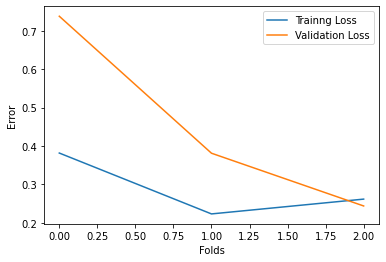

In [19]:
plt.plot(train_loss, label = "Trainng Loss")
plt.plot(vald_loss, label = "Validation Loss")
# naming the x axis 
plt.xlabel('Folds') 
# naming the y axis 
plt.ylabel('Error') 
# function to show the plot 
plt.legend()
plt.savefig('RNN_results/Plots/RNN_loss_check.png')

In [20]:
test_loss = []
RNN_test_input = np.stack(RNN_test_input)
with tf.device('/device:GPU:0'):
  for i in range(n_splits):
    checkpoint_filepath = 'RNN_results/CheckPoints/RNN_checkpoint'+str(i+1) 
    best_model = tf.keras.models.load_model(
                                            checkpoint_filepath, custom_objects=None, compile=True, options=None
                                            )
    predicted = best_model.predict(RNN_test_input)
    
    loss_test = best_model.evaluate(RNN_test_input,RNN_test_output, verbose=0)
    print("Test Errror for the fold ",i+1," is",loss_test )
    
    
    plt.plot(predicted[0:50], label = "Predicted Values")  
    plt.plot(RNN_test_output[0:50], label = "Actual Values")
    # naming the x axis 
    plt.xlabel('Test Samples') 
    # naming the y axis 
    plt.ylabel('Output Values') 
    # function to show the plot 
    plt.legend()
    textstr = "Test Errror for the fold "+ str(i+1)+" is "+str(np.round(loss_test,3))
    plt.gcf().text(0, -0.25, textstr, fontsize=14)
    plt.savefig('RNN_results/Plots/RNN_fold'+str(i+1)+'.png',bbox_inches='tight')
    plt.clf()

    test_loss.append(loss_test)

Test Errror for the fold  1  is 0.911624014377594
Test Errror for the fold  2  is 0.23070578277111053
Test Errror for the fold  3  is 0.330750435590744


<Figure size 432x288 with 0 Axes>

Training Loss: 0.289 (0.068)
Validation Loss: 0.454 (0.208)
Test Loss: 0.491 (0.300)


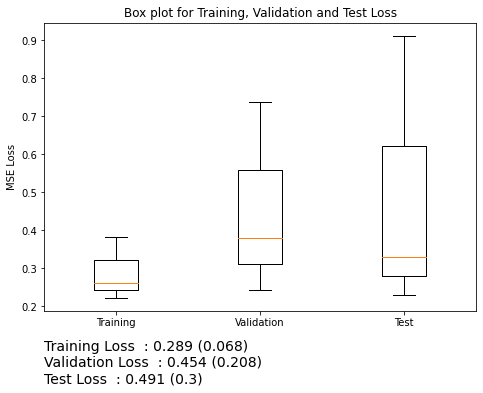

In [24]:
import matplotlib.pylab as plt
data=[]
data.append(train_loss)
data.append(vald_loss)
data.append(test_loss)
  
fig = plt.figure()  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
  
# Creating plot 
ax.boxplot(data)

ax.set_xticklabels(['Training', 'Validation','Test']) 

# naming the y axis 
plt.ylabel('MSE Loss')
plt.title("Box plot for Training, Validation and Test Loss")
textstr ='Training Loss  : '+str(np.round(np.mean(train_loss),3))+' ('+str(np.round(np.std(train_loss),3))+')\n'+'Validation Loss  : '+str(np.round(np.mean(vald_loss),3))+' ('+str(np.round(np.std(vald_loss),3))+')\n'+'Test Loss  : '+str(np.round(np.mean(test_loss),3))+' ('+str(np.round(np.std(test_loss),3))+')'
plt.gcf().text(0, -0.25, textstr, fontsize=14)
# show plot 
plt.savefig('RNN_results/Plots/block_RNN.png',bbox_inches='tight')

print('Training Loss: %.3f (%.3f)' % (np.mean(train_loss), np.std(train_loss)))
print('Validation Loss: %.3f (%.3f)' % (np.mean(vald_loss), np.std(vald_loss)))
print('Test Loss: %.3f (%.3f)' % (np.mean(test_loss), np.std(test_loss)))

In [25]:
!zip -r /content/file.zip /content/RNN_results
from google.colab import files
files.download("/content/file.zip")

  adding: content/RNN_results/ (stored 0%)
  adding: content/RNN_results/.ipynb_checkpoints/ (stored 0%)
  adding: content/RNN_results/CheckPoints/ (stored 0%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint1/ (stored 0%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint1/variables/ (stored 0%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint1/variables/variables.index (deflated 47%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint1/assets/ (stored 0%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint1/saved_model.pb (deflated 89%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint3/ (stored 0%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint3/variables/ (stored 0%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint3/variables/variables.index (deflated 47%)
  adding: content/RNN_results/CheckPoints/RNN_checkpoint3/va

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>